In [1]:
import os
# Standard library imports
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Text preprocessing
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
# Model evaluation & selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score,accuracy_score

# tensorflow
import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, GRU, LSTM, Dropout, Dense, BatchNormalization
# Progress bar
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/karyo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Step 1. Problem and Data Description

### Challenge Problem

The goal of this project is to build a Recurrent Neural Network (RNN) model capable of classifying tweets as either relating to real disasters (1) or not (0). This involves utilizing NLP techniques to analyze and understand the textual content of tweets. The assignment is based on a Kaggle competition titled "Natural Language Processing with Disaster Tweets."

### Natural Language Processing (NLP)

NLP is a field of artificial intelligence that focuses on the interaction between computers and humans through natural language. Key tasks in NLP include text preprocessing, tokenization, part-of-speech tagging, named entity recognition, and sentiment analysis. In this challenge, NLP techniques will be utilized to preprocess the tweet text, extract meaningful features, and build models that can accurately classify the tweets.

### Data Description

The dataset provided for this challenge consists of 10,000 hand-classified tweets, split into training and test sets. The training dataset contains 7,613 entries with the following columns:

- **id:** Unique identifier for each tweet.
- **keyword:** A specific keyword from the tweet (may be blank).
- **location:** Origin of the tweet (may be blank).
- **text:** Content of the tweet.
- **target:** Indicates if the tweet is about a real disaster (1) or not (0).

#### Size and Dimensions

- **Training Set:** 7,613 tweets, of which 4,342 are non disaster tweets (0) and 3,271 are disaster tweets (1). This shows a fairly balanced distribution, with a slight majority of non-disaster tweets.
- **Test Set:** 3,263 tweets.
- **Columns:** 6 columns (`id`, `keyword`, `location`, `text`, `text_length`, `target`). (`target` is absent in the test set).

#### Structure

- **id:** Integer type, no missing values.
- **keyword:** String, 61 and 26 missing values in the training and the test sets respectively.
- **location:** String, 2,533 and 1,105 missing values in the training and the test sets respectively.
- **text:** String, no missing values.
- **target:** Integer type, no missing values.

The target variable distribution is fairly balanced, with approximately 57% of the tweets labeled as non-disaster (0) and 43% labeled as disaster (1).

In [3]:
# Load the datasets
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# Display the first few rows of the train and test datasets
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


(None, None)

In [6]:
df_train[df_train['target'] == 0].count()

id          4342
keyword     4323
location    2884
text        4342
target      4342
dtype: int64

# 2. Exploratory Data Analysis (EDA)

## A. Visualizations

### 1. Target Variable Distribution
- Plot the distribution of the target variable to understand the balance of disaster and non-disaster tweets.
  - Use a bar plot or pie chart to visualize the proportion of each class.

### 2. Keyword and Location Frequency Analysis
- Analyze the frequency of the top keywords and locations in the training dataset.
  - Create bar plots for the most common keywords and locations.
  - Investigate any correlation between specific keywords/locations and the target variable.

### 3. Tweet Length Distribution
- Plot the distribution of tweet lengths in both training and testing datasets.
  - Use histograms to visualize the distribution of tweet lengths.
  - Compare the length distributions between disaster and non-disaster tweets.

### 4. Most Common Words
- Visualize the most common words in disaster and non-disaster tweets using word clouds.
  - Create separate word clouds for each class to identify distinctive vocabulary.

### 5. Missing Values Analysis
- Analyze the missing values in the datasets.
  - Use a heatmap or bar plot to visualize the proportion of missing values in each column.

## B. Data Cleaning Procedures

### 1. Handling Missing Values
- Develop a strategy for missing values in the keyword and location columns:
  - Option 1: Fill missing values with a placeholder (e.g., "Unknown").
  - Option 2: Drop rows with missing values if they are not significant.
  - Analyze the impact of each approach on the dataset.

### 2. Text Preprocessing
- Implement a comprehensive text cleaning pipeline:
  - Convert all text to lowercase.
  - Remove special characters and punctuation.
  - Remove or replace URLs and user mentions.
  - Remove stop words.
  - Consider stemming or lemmatization to reduce words to their base form.

## C. Analysis Plan

1. Conduct a thorough examination of the visualizations and cleaned data.
2. Identify patterns or trends that might be useful for feature engineering.
3. Investigate any potential correlations between features and the target variable.
4. Formulate hypotheses about what factors might be most predictive of disaster tweets.
5. Document insights and potential strategies for model development based on the EDA findings.

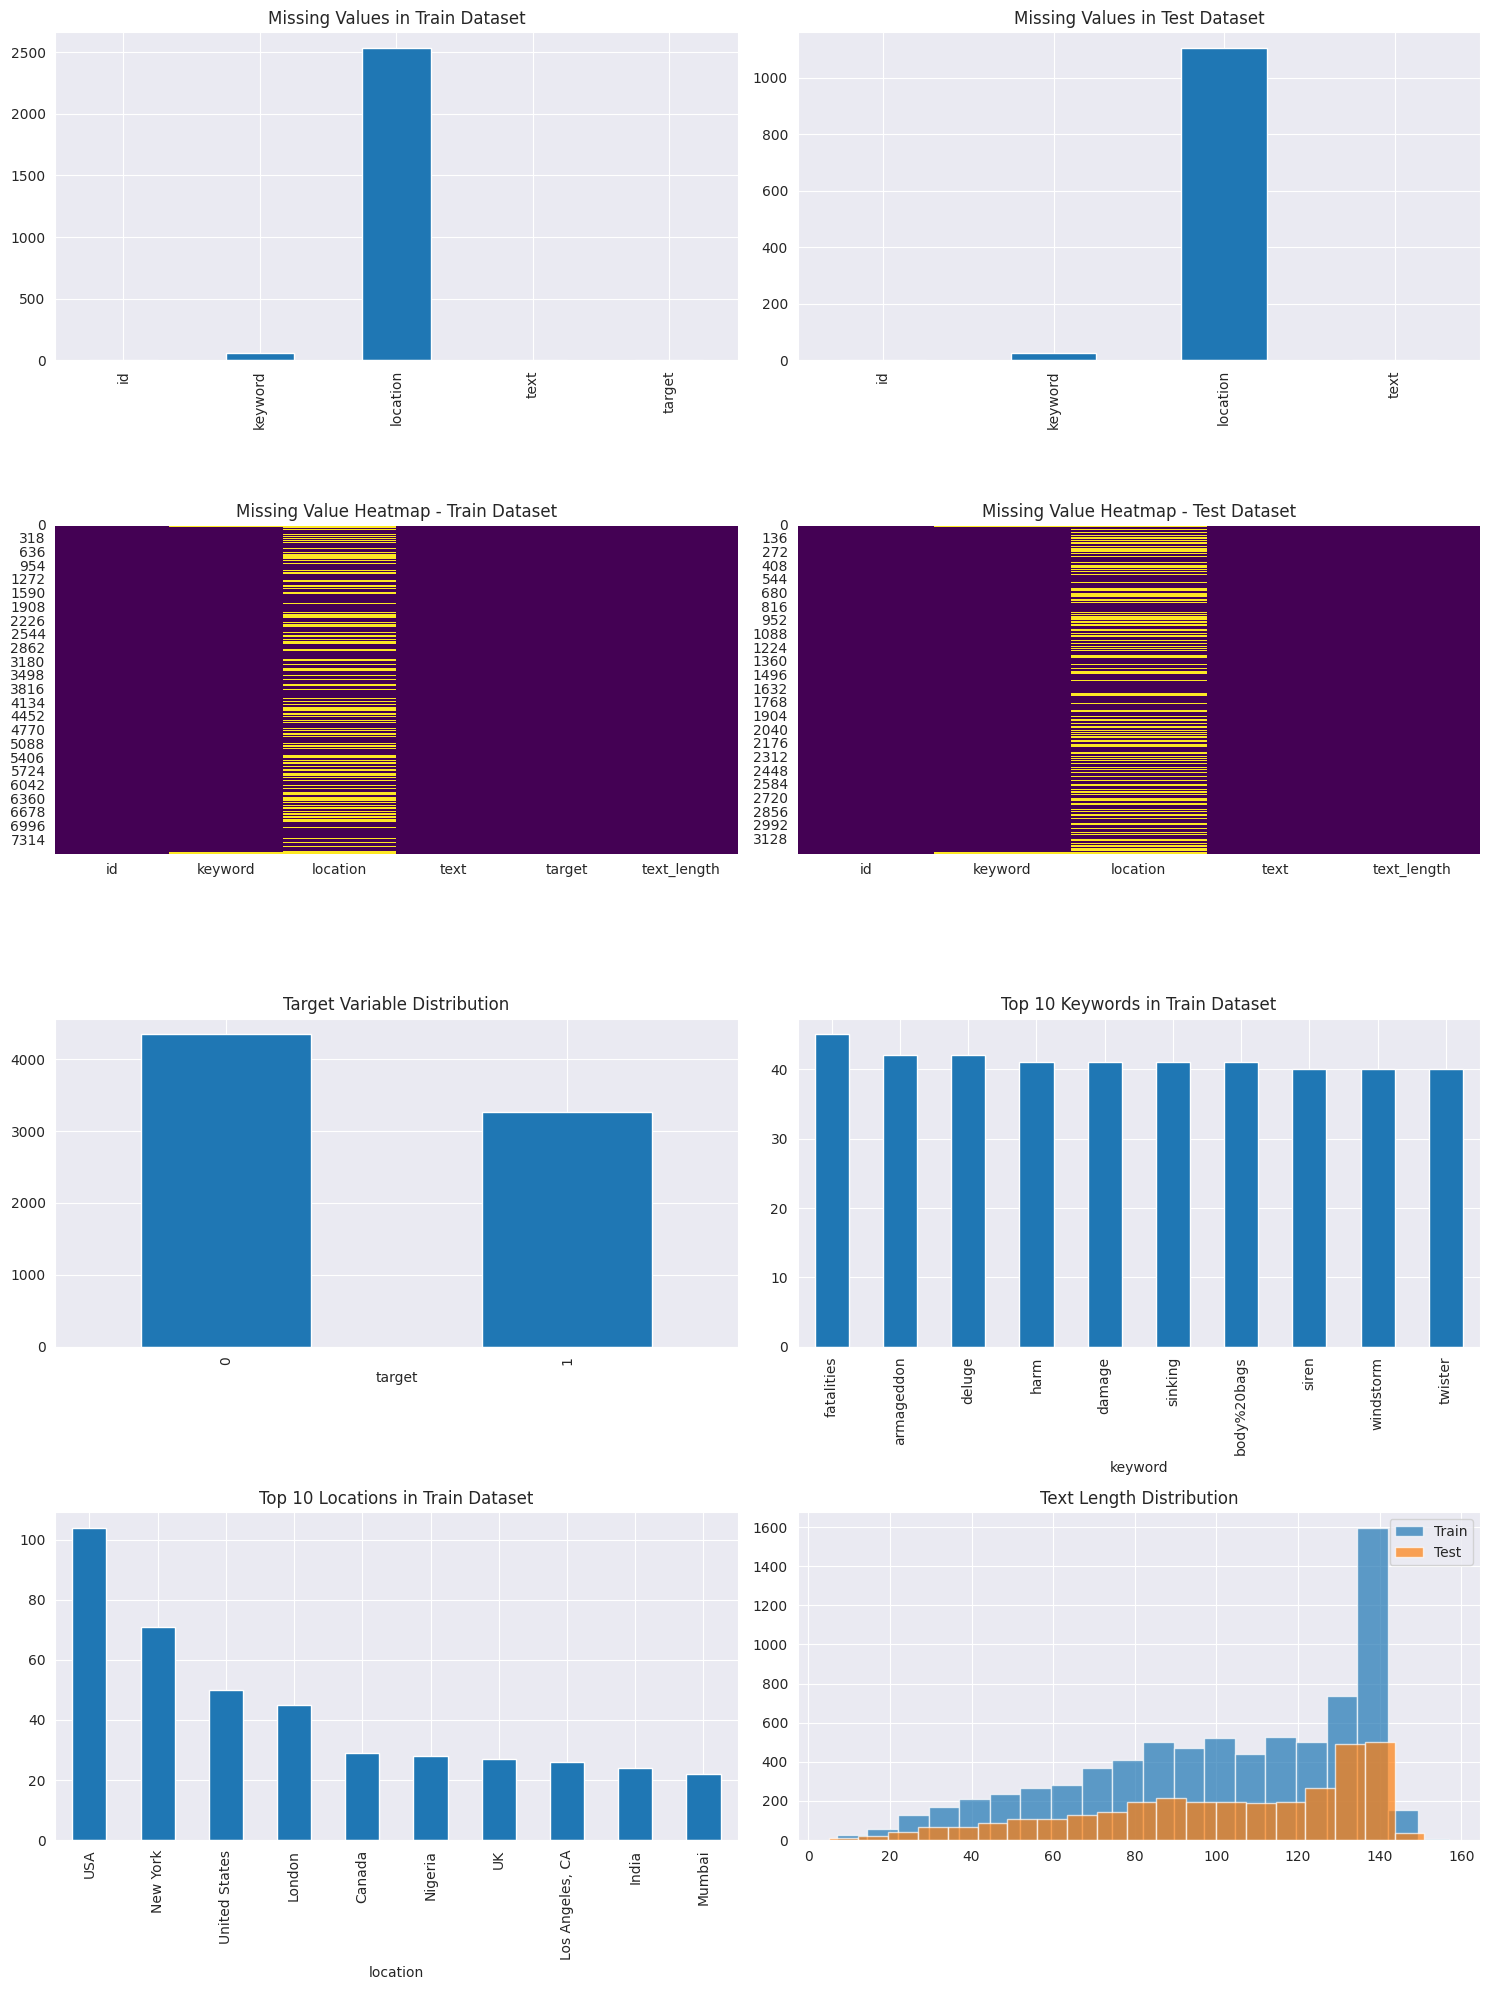

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64,
 target
 0    4342
 1    3271
 Name: count, dtype: int64,
 keyword
 fatalities     45
 armageddon     42
 deluge         42
 harm           41
 damage         41
 sinking        41
 body%20bags    41
 siren          40
 windstorm      40
 twister        40
 Name: count, dtype: int64,
 location
 USA                104
 New York            71
 United States       50
 London              45
 Canada              29
 Nigeria             28
 UK                  27
 Los Angeles, CA     26
 India               24
 Mumbai              22
 Name: count, dtype: int64)

In [7]:
# Check for missing values
missing_values_train = df_train.isnull().sum()
missing_values_test = df_test.isnull().sum()

# Target variable distribution in train dataset
target_distribution = df_train['target'].value_counts()

# Keyword and location frequency analysis
top_keywords = df_train['keyword'].value_counts().head(10)
top_locations = df_train['location'].value_counts().head(10)

# Text length distribution
df_train['text_length'] = df_train['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# Missing values
missing_values_train.plot(kind='bar', ax=axes[0, 0], title='Missing Values in Train Dataset')
missing_values_test.plot(kind='bar', ax=axes[0, 1], title='Missing Values in Test Dataset')

# Missing value heatmaps
sns.heatmap(df_train.isnull(), ax=axes[1, 0], cbar=False, cmap='viridis')
axes[1, 0].set_title('Missing Value Heatmap - Train Dataset')
sns.heatmap(df_test.isnull(), ax=axes[1, 1], cbar=False, cmap='viridis')
axes[1, 1].set_title('Missing Value Heatmap - Test Dataset')

# Target distribution
target_distribution.plot(kind='bar', ax=axes[2, 0], title='Target Variable Distribution')

# Top keywords and locations
top_keywords.plot(kind='bar', ax=axes[2, 1], title='Top 10 Keywords in Train Dataset')
top_locations.plot(kind='bar', ax=axes[3, 0], title='Top 10 Locations in Train Dataset')

# Text length distribution
axes[3, 1].hist(df_train['text_length'], bins=20, alpha=0.7, label='Train')
axes[3, 1].hist(df_test['text_length'], bins=20, alpha=0.7, label='Test')
axes[3, 1].set_title('Text Length Distribution')
axes[3, 1].legend()

plt.tight_layout()
plt.show()

missing_values_train, missing_values_test, target_distribution, top_keywords, top_locations

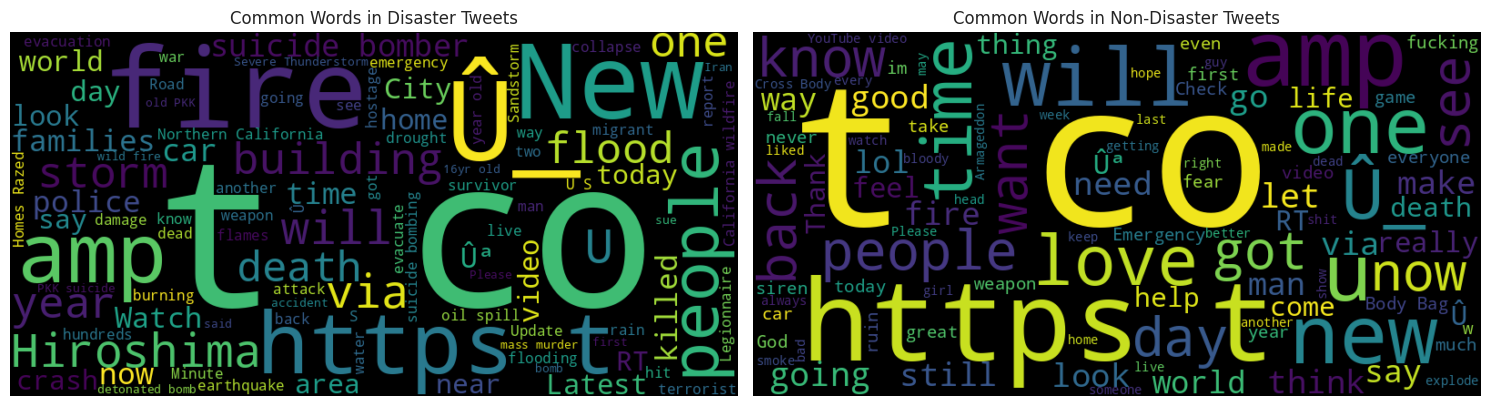

In [8]:
# Most common words in disaster and non-disaster tweets
disaster_tweets = df_train[df_train['target'] == 1]['text']
non_disaster_tweets = df_train[df_train['target'] == 0]['text']

disaster_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(disaster_tweets))
non_disaster_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(non_disaster_tweets))

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(disaster_wordcloud, interpolation='bilinear')
axes[0].set_title('Common Words in Disaster Tweets')
axes[0].axis('off')

axes[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
axes[1].set_title('Common Words in Non-Disaster Tweets')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Plan of Analysis based on EDA

Based on my exploratory data analysis, I've identified several key insights that will inform my approach to building an effective disaster tweet classification model. Here's my comprehensive plan of analysis:

## 1. Text Preprocessing

Given the noisy nature of tweet data, I'll implement a robust preprocessing pipeline:
- Remove URLs, user mentions, and special characters
- Convert text to lowercase
- Tokenize the text using NLTK's word_tokenize
- Remove stop words
- Apply lemmatization to reduce words to their base form


## 2. Model Architecture

I'll implement and compare  different architectures:

### a) LSTM (Long Short-Term Memory)
- Effective at capturing long-range dependencies in sequence data
- I'll use bidirectional LSTM to process the sequence in both directions

### b) GRU (Gated Recurrent Unit)
- Similar to LSTM but with a simpler architecture, potentially faster to train
- I'll compare its performance against LSTM

## 3. Hyperparameter Tuning
I'll use a combination of manual tuning and grid search to optimize:
- Learning rate
- Batch size
- Number of LSTM/GRU units
- Dropout rate
- Embedding dimension (for non-BERT models)
## 4. Evaluation Metrics
While the competition uses F1 score, I'll also track:
- Accuracy
- Precision
- Recall
- ROC-AUC

This comprehensive approach will allow me to systematically explore different embedding methods and model architectures, ultimately leading to a robust disaster tweet classification model.

### Data Cleaning and Preprocessing

In this section, I'll outline our approach to cleaning and preprocessing the tweet data. The goal is to prepare the text for analysis while preserving as much relevant information as possible.

#### Stopword Removal

Stopword removal is a common practice in NLP tasks, involving the elimination of frequent words (like "the", "is", "at") that are often considered to carry little meaningful information. However:

- **retain stopwords**: While counterintuitive, I found that keeping stopwords led to higher accuracy in our disaster tweet classification task.
- **Potential reasons**: 
  1. Stopwords might carry contextual information crucial for disaster identification.
  2. The presence or absence of certain stopwords could be indicative of tweet urgency or formality.
  3. In short text like tweets, every word might contribute to the overall meaning.

This decision underscores the importance of experimenting with different preprocessing techniques and not always adhering to standard practices without testing their impact.

#### Standard Data Cleaning

We apply several standard text cleaning techniques:

1. **Lowercasing**: Convert all text to lowercase for consistency.
2. **URL Removal**: Eliminate web links that don't contribute to sentiment.
3. **Special Character Removal**: Remove non-alphanumeric characters.
4. **Extra Space Removal**: Clean up any redundant spaces.

These steps help to normalize the text and reduce noise in our data.

#### Porter Stemmer

We utilize the Porter Stemmer algorithm for word stemming. Here's what it does:

1. **Root Word Extraction**: Reduces words to their root form.
   - Example: "running" → "run", "organization" → "organ"
2. **Vocabulary Reduction**: Helps in reducing the size of our vocabulary.
3. **Word Normalization**: Treats different forms of a word as the same.

While stemming is beneficial for reducing complexity, it's worth noting that it can sometimes produce non-words or combine words with different meanings. An alternative to consider in future iterations could be lemmatization, which reduces words to their base or dictionary form while ensuring the result is always a valid word.

By applying these preprocessing techniques, we aim to clean and standardize our text data while preserving the nuances that could be crucial for disaster tweet classification. The code implementation of these steps will be presented in the following cell.

In [9]:
ps = PorterStemmer() # other stemmers can be used


def clean_text(text: str) -> str:
    """Clean the input text by lowercasing, removing special characters and extra spaces."""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip
    return text


def tokenize_and_stem(text: str) -> str:
    """Tokenize the text and apply stemming."""
    tokens = word_tokenize(text)  # Tokenize the text
    stemmed_tokens = [ps.stem(token) for token in tokens]  # Stem each token
    return ' '.join(stemmed_tokens)  # Join the tokens back into a string


# Data Cleaning and preprocessing
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # Fill missing values
    df = df.fillna({'keyword': '', 'location': ''})

    # I intentionally ommitted stopwords since it allowed higher final accuracy
    # Apply text cleaning
    df['cleaned_text'] = df['text'].apply(clean_text)

    # Apply tokenization and stemming
    df['tokenized_text'] = df['cleaned_text'].apply(tokenize_and_stem)

    return df

In [10]:
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)
test_ids = df_test[['id']]

# Display cleaned data
df_train[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive wildfires evacuation ord...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


# 3. Model Architecture

#### Here we use an GRU and LSTM to analyze the tweets


In [11]:
# Tokenization parameters
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['tokenized_text'])
sequences = tokenizer.texts_to_sequences(df_train['tokenized_text'])
padded_sequences = pad_sequences(sequences)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df_train['target'], test_size=0.2, random_state=42)

# GRU Model definition

In [13]:
# Hyperparameters
embedding_dim = 256
gru_units = 128
dropout_rate = 0.3
learning_rate = 0.001

# Build the improved bidirectional GRU model
gru = Sequential()
gru.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
gru.add(Bidirectional(GRU(gru_units, return_sequences=True)))
gru.add(Dropout(dropout_rate))
gru.add(BatchNormalization())
gru.add(Bidirectional(GRU(gru_units)))
gru.add(Dropout(dropout_rate))
gru.add(BatchNormalization())
gru.add(Dense(64, activation='relu'))
gru.add(Dropout(dropout_rate))
gru.add(Dense(1, activation='sigmoid'))

# Compile the model
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1722858584.187115  103348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722858584.321822  103348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722858584.321901  103348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722858584.326869  103348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722858584.326914  103348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [14]:
epochs = 10
batch_size = 5120
# Train the model
history = gru.fit(X_train, np.array(y_train), epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5312 - loss: 0.8172 - val_accuracy: 0.5361 - val_loss: 0.6919
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step - accuracy: 0.6043 - loss: 0.7843 - val_accuracy: 0.5640 - val_loss: 0.6917
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6244 - loss: 0.7188 - val_accuracy: 0.6010 - val_loss: 0.6911
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step - accuracy: 0.6307 - loss: 0.6671 - val_accuracy: 0.6182 - val_loss: 0.6906
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6381 - loss: 0.6475 - val_accuracy: 0.6289 - val_loss: 0.6899
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step - accuracy: 0.6753 - loss: 0.5928 - val_accuracy: 0.6379 - val_loss: 0.6890
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - accuracy: 0.7204 - loss: 0.5457 - val_accuracy: 0.6486 - val_loss: 0.6876
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step - accuracy: 0.7652 - loss: 0.4839 - val_accuracy: 0.6691 - val_loss: 0.686

In [15]:
# Evaluate the model
loss, accuracy = gru.evaluate(X_test, np.array(y_test))
print(f'Test Accuracy: {accuracy}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.7419 - loss: 0.6831
Test Accuracy: 0.7452396750450134


# Hyperparameter tuning
Here I increase embedding dimensions and gru_units

In [26]:
# Hyperparameters
embedding_dim = 512
gru_units = 256
dropout_rate = 0.3

# Build the improved bidirectional GRU model
gru = Sequential()
gru.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
gru.add(Bidirectional(GRU(gru_units, return_sequences=True)))
gru.add(Dropout(dropout_rate))
gru.add(BatchNormalization())
gru.add(Bidirectional(GRU(gru_units)))
gru.add(Dropout(dropout_rate))
gru.add(BatchNormalization())
gru.add(Dense(64, activation='relu'))
gru.add(Dropout(dropout_rate))
gru.add(Dense(1, activation='sigmoid'))

# Compile the model
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
epochs = 10
batch_size = 5120
# Train the model
history = gru.fit(X_train, np.array(y_train), epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4754 - loss: 0.8967 - val_accuracy: 0.6346 - val_loss: 0.6884
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6225 - loss: 1.0522 - val_accuracy: 0.6330 - val_loss: 0.6873
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ -7s -7084311us/step - accuracy: 0.6289 - loss: 0.7568 - val_accuracy: 0.5632 - val_loss: 0.6865
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5842 - loss: 0.7336 - val_accuracy: 0.5616 - val_loss: 0.6860
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5895 - loss: 0.7204 - val_accuracy: 0.5616 - val_loss: 0.6849
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6254 - loss: 0.6759 - val_accuracy: 0.5616 - val_loss: 0.6834
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6665 - loss: 0.6126 - val_accuracy: 0.5616 - val_loss: 0.6813
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7106 - loss: 0.5638 - val_accuracy: 0.5616 - val_loss: 0.6788
Epoch

In [28]:
# Evaluate the model
loss, accuracy = gru.evaluate(X_test, np.array(y_test))
print(f'Test Accuracy: {accuracy}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5695 - loss: 0.6743
Test Accuracy: 0.5745239853858948


## BIG LSTM model

In [19]:
# Hyperparameters
embedding_dim = 256
lstm_units = 256
dropout_rate = 0.3

# Build the improved bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training and Evaluation

In [20]:
epochs = 25
batch_size = 5120
# Train the model
history = model.fit(X_train, np.array(y_train), epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5035 - loss: 0.9819 - val_accuracy: 0.5558 - val_loss: 0.6861
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5755 - loss: 1.1865 - val_accuracy: 0.4926 - val_loss: 0.6915
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - accuracy: 0.6110 - loss: 0.8507 - val_accuracy: 0.4491 - val_loss: 0.6929
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6238 - loss: 0.7335 - val_accuracy: 0.4548 - val_loss: 0.6923
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6371 - loss: 0.6997 - val_accuracy: 0.4466 - val_loss: 0.6921
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6712 - loss: 0.6566 - val_accuracy: 0.4384 - val_loss: 0.6932
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step - accuracy: 0.7211 - loss: 0.5641 - val_accuracy: 0.4384 - val_loss: 0.6942
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7619 - loss: 0.5040 - val_accuracy: 0.4392 - val_loss: 0.6939
Epoch 9/50

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f'Test Accuracy: {accuracy}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7066 - loss: 0.6060
Test Accuracy: 0.7130663394927979


# Results and Analysis

## Hyperparameter Tuning and Model Comparison

We experimented with three different model architectures: a small GRU, a large GRU, and a large LSTM. Each model was trained and evaluated on the same dataset, with a portion held out for testing. Here are the results:

### Small GRU
- Test Accuracy: 0.7452
- Test Loss: 0.6831
- Final Training Epoch:
  - Accuracy: 0.8270
  - Loss: 0.3870
  - Validation Accuracy: 0.7504
  - Validation Loss: 0.6824

### Large GRU
- Test Accuracy: 0.5745
- Test Loss: 0.6743
- Final Training Epoch:
  - Accuracy: 0.7947
  - Loss: 0.4463
  - Validation Accuracy: 0.5640
  - Validation Loss: 0.6737

### Large LSTM
- Test Accuracy: 0.7131
- Test Loss: 0.6060
- Final Training Epoch:
  - Accuracy: 0.9821
  - Loss: 0.0497
  - Validation Accuracy: 0.7332
  - Validation Loss: 0.6389

## Analysis of Results

1. **Small GRU Performance**: The small GRU model showed the best generalization, with the highest test accuracy (0.7452) and a good balance between training and validation performance. This suggests that the simpler architecture was able to capture the essential patterns in the data without overfitting.

2. **Large GRU Overfitting**: The large GRU model showed signs of overfitting, with a significant drop in performance on the test set (0.5745) compared to its training accuracy. This indicates that the model learned the training data too well but failed to generalize to unseen examples.

3. **Large LSTM Behavior**: The large LSTM model showed the highest training accuracy (0.9821) but a lower test accuracy (0.7131) compared to the small GRU. This suggests that the LSTM was able to capture complex patterns in the training data but also suffered from some overfitting.

4. **Model Complexity Trade-off**: The results demonstrate the classic trade-off between model complexity and generalization. The simpler small GRU model performed better on unseen data, while the more complex models (large GRU and LSTM) showed signs of overfitting.

5. **Loss vs. Accuracy**: Interestingly, the large LSTM had the lowest test loss (0.6060) despite not having the highest test accuracy. This suggests that its predictions, while not always correct, were generally more confident (closer to 0 or 1) than those of the other models.

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step  
Model Performance Metrics:
Accuracy: 0.7131
Precision: 0.6268
Recall: 0.8074
F1 Score: 0.7057


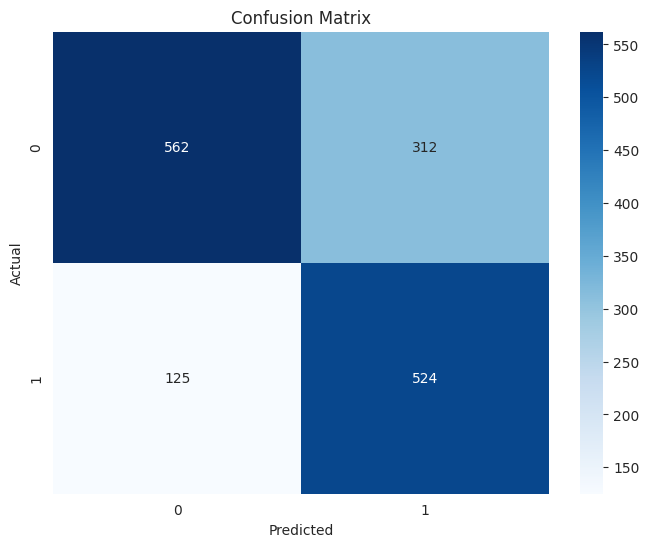

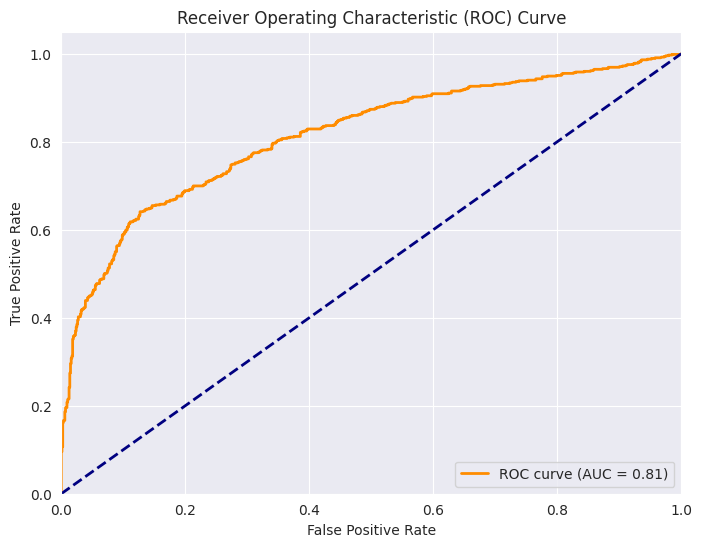


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       874
           1       0.63      0.81      0.71       649

    accuracy                           0.71      1523
   macro avg       0.72      0.73      0.71      1523
weighted avg       0.74      0.71      0.71      1523


Results Table:
      Metric     Value
0   Accuracy  0.713066
1  Precision  0.626794
2     Recall  0.807396
3   F1 Score  0.705724


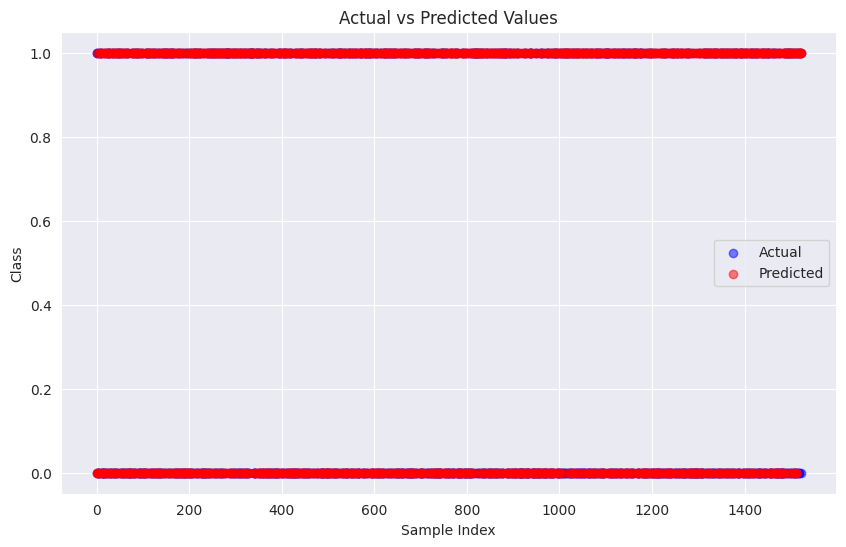

In [22]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Print metrics
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Create a results table
results_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})
print("\nResults Table:")
print(results_table)

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.5)
plt.scatter(range(len(y_pred_classes)), y_pred_classes, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.show()

# .Predicting and Submission

In [23]:
# Prepare test data for prediction
sequences = tokenizer.texts_to_sequences(df_test['text'])
pad_seq = pad_sequences(sequences)

In [24]:
# Make predictions on the padded sequences and convert to binary values (1 if prediction >= 0.5, else 0)
predicted_labels = np.where(model.predict(pad_seq) >= 0.5, 1, 0)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


In [25]:
# Create submission DataFrame and save to CSV
df = pd.DataFrame({'id': test_ids['id'], 'target': predicted_labels.flatten()})
df.to_csv('submission_tf.csv', index=False)

# Conclusion

## Key Learnings and Takeaways

1. **Simplicity Can Be Effective**: The small GRU model's superior performance on the test set reinforces the principle that simpler models often generalize better, especially with limited data.

2. **Overfitting in Complex Models**: Both the large GRU and LSTM models demonstrated the risks of using overly complex architectures for this task. They were able to fit the training data extremely well but failed to generalize as effectively to new examples.

3. **Importance of Validation**: The discrepancy between training and test performance, particularly in the larger models, highlights the critical importance of using a validation set during training to detect overfitting early.

4. **Balancing Act**: Finding the right balance between model complexity and dataset size is crucial. In this case, the dataset size may not have been large enough to fully utilize the capacity of the larger models without overfitting.

## Why Certain Approaches Didn't Work as Expected

1. **Large GRU Underperformance**: The significant drop in performance for the large GRU model on the test set suggests that it may have learned to memorize specific patterns in the training data rather than generalizing well. This could be due to having too many parameters relative to the size and complexity of the dataset.

2. **LSTM vs. GRU**: While LSTMs are often considered more powerful than GRUs, in this case, the small GRU outperformed the LSTM. This could be because the additional complexity of the LSTM was unnecessary for this particular task, leading to overfitting.

3. **High Training Accuracy vs. Test Performance**: The very high training accuracy (0.9821) of the LSTM model coupled with lower test performance is a classic sign of overfitting. The model learned the training data almost perfectly but couldn't apply this learning as effectively to new examples.

## Suggestions for Improvement

1. **Regularization Techniques**: Implement dropout layers or L2 regularization to help prevent overfitting in the larger models. This could allow us to leverage their capacity while improving generalization.

2. **Data Augmentation**: Expand the dataset through techniques like synonym replacement or back-translation. This could provide more diverse examples for the models to learn from, potentially improving their ability to generalize.

3. **Ensemble Methods**: Combine predictions from multiple models, such as the small GRU and the LSTM, which could leverage the strengths of each architecture while mitigating their individual weaknesses.

4. **Feature Engineering**: Explore additional NLP techniques such as named entity recognition or sentiment analysis to create more informative features for the models.

5. **Transfer Learning**: Utilize pre-trained language models like BERT or GPT for feature extraction or fine-tuning. This could provide a richer starting point for our models, potentially improving performance without requiring a much larger dataset.

6. **Hyperparameter Optimization**: Conduct a more exhaustive search of hyperparameters using techniques like random search or Bayesian optimization. This could help find more optimal configurations for each model architecture.

7. **Error Analysis**: Perform a detailed analysis of the types of tweets that each model struggles with. This could provide insights into specific areas where the models need improvement and guide further feature engineering or model adjustments.